In [2]:
# 2.ipynb得到
# 所有策略都是通道突破策略

In [3]:
# 我们把上界p设出来，看看p应该是多少
# 也就是说，计算首达时 Tₚ=min{t|Wₜ=p}, 首达概率fⁿₚ=P(Tₚ=n), 有限步首达概率fₚ=∑fⁿₚ 
# 收益是p*fₚ
# FPT: first passage time
# 现在有没有FPT的解析解？
# https://userswww.pd.infn.it/~orlandin/fisica_sis_comp/first_passage.pdf

In [4]:
# OU本身有解析解
# dXt=-Θ*Xt*dt+σ*dWt
# dXt+Θ*Xt*dt=σ*dWt
# d(eᶿᵗXt)=σ*eᶿᵗ*dWt
# Xt=σ∫ᵗe⁻ᶿ⁽ᵗ⁻ˢ⁾dWs
# Xt=μ+e⁻ᶿᵗ(X0-μ)+σ∫ᵗe⁻ᶿ⁽ᵗ⁻ˢ⁾dWs

In [5]:
# 还能再化简
# Ito积分
# https://zh.wikipedia.org/wiki/%E4%BC%8A%E8%97%A4%E7%A7%AF%E5%88%86
# 伊藤引理
# Itô integral of deterministic integrand is normally distributed
# ∫ᵗe⁻ᶿ⁽ᵗ⁻ˢ⁾dWs方差是∫ᵗe⁻²ᶿ⁽ᵗ⁻ˢ⁾ds=(1-e⁻²ᶿᵗ)/2θ
# 所以 Xt=σ*W[(1-e⁻²ᶿᵗ)/2θ]
# 完全确定

In [6]:
# 布朗运动的首达时
# https://zhuanlan.zhihu.com/p/348017706
# P(Tₐ<t)=2[1-Φ(|a|/√t)]
# P(Tₐ<∞)=1 几乎处处有限
# E[Tₐ]=∞ 期望是无穷
# UO运动的首达时
# P(Tₚ<t)=P(inf{t|Xₜ=p}<t)=P(inf{t|W[(1-e⁻²ᶿᵗ)/2θ]=p/σ}<t)
# P(Tₚ<t)=P(inf{t|Wt=p/σ}<(1-e⁻²ᶿᵗ)/2θ) = P(T_[p/σ]<(1-e⁻²ᶿᵗ)/2θ)
# P(Tₚ<t)=2(1-Φ{|p/σ|/√[(1-e⁻²ᶿᵗ)/2θ]})
# p_Tₚ(t)=2[p*√(2θ)/σ]*...*φ{|p/σ|/√[(1-e⁻²ᶿᵗ)/2θ]}+δ(∞) |||||||||||
# 令t=∞, 于是结果是2{1-Φ[p*√(2θ)/σ]}
# max p*2{1-Φ[p*√(2θ)/σ]}
# 然后数值，模拟退火
# ？？我算的不对？应该是几乎处处有限的，应该总能达到
# Xt=σ*W[(1-e⁻²ᶿᵗ)/2θ]只在没有吸收的时候成立
# 因为越过p又折返回来的路径有贡献
# 但也不对？我把时间轴拉一下它不就是布朗
# ？？？？？

In [7]:
# 但是，对于一条没有撞上墙的轨迹，它的期望是0吗？不是
# 有一个稳定分布f(x),x<p,吗啊？

In [8]:
using DifferentialEquations
# https://github.com/SciML/DiffEqNoiseProcess.jl
using Distributions
using Plots
using Optim # 里面列了不需要一阶信息的算法

In [18]:
Θ=1.0
σ=1.0
f(p)=p*2*(1-cdf(Normal(0,1),p*sqrt(2Θ)/σ))
res=optimize(x->-f(first(x)),[0.0])

 * Status: success

 * Candidate solution
    Final objective value:     -2.403756e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    19


In [19]:
summary(res)
Optim.minimizer(res)

1-element Vector{Float64}:
 0.5315429687500002

In [20]:
Optim.minimum(res)

-0.24037558505702017

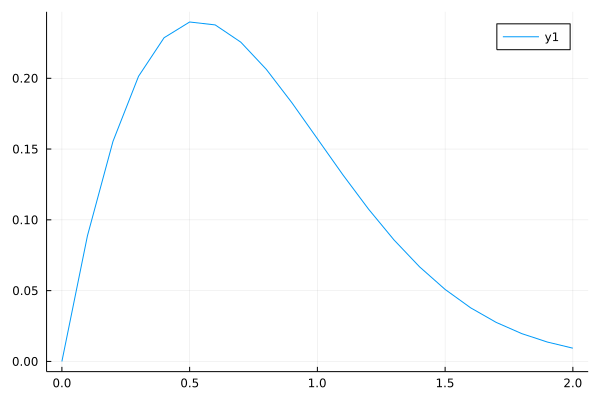

In [21]:
x=0:0.1:2
plot(x,f.(x))

In [119]:
# 这就和Fokker-Planck有关系了
# 鞅：未来的期望等于现在的值
Θ=1.0
μ=100.0
σ=1.0
t0=0.0
dt=0.01
T=1000.0
function FPT(a,b) #首达时间
    if a==b
        return 0.0
    end 
    X=OrnsteinUhlenbeckProcess(Θ,μ,σ,t0,μ+a)
    X.dt=dt
    calculate_step!(X,dt,nothing,nothing)
    for t in dt:dt:T
        accept_step!(X,dt,nothing,nothing)
        if a<b && X.curW>μ+b
            return X.curt
        end
        if a>b && X.curW<μ+b
            return X.curt
        end
    end
    return Inf
end

FPT (generic function with 1 method)

Reached: 1.0


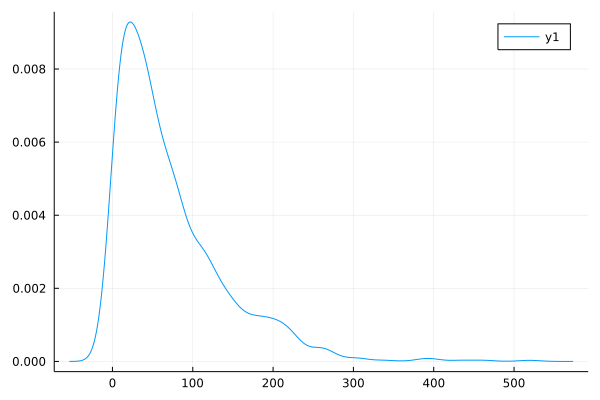

In [118]:
# 固定ab，看FPT的分布
using KernelDensity
function pdf_FPT(a,b)
    N=1000
    S=Array{Float64}(undef,N)
    for i in 1:N
        S[i]=FPT(a,b)
    end
    sort!(S)
    r=searchsorted(S,Inf)
    U = kde(@view S[1:r.start-1])
    return U,1-length(r)/length(S)
end
U,p_reached=pdf_FPT(0,2)
println("Reached: $p_reached")
plot(U.x,U.density)

In [120]:
# 我们能证明有限步以内必定能达到！
# 首先，如果没有吸收点，UO过程永远熟练到一个正态分布
# 然后，把尾巴切掉，等价于以某个比例吸收
# 再扩散，再切
# 最后剩下的是等比数列，收敛到0

In [121]:
# ！！！所以一旦时间足够长，一定能撞上墙
# 所以p处的收益永远是p
# 把p设的足够大，收益可以是正无穷！